# 1. Read the file, skipping comment lines

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score # Evaluation
# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Random Forest training
from sklearn.preprocessing import StandardScaler # Scaling
# SMOTE balancing
from imblearn.over_sampling import SMOTE

In [7]:
koi = pd.read_csv(
    '/content/cumulative.csv',
    comment='#',         # Ignore any lines starting with #
    skip_blank_lines=True,
    low_memory=False
)

# 2. Inspect first rows to confirm you have the right columns

In [8]:
print(koi.columns)


Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')


In [9]:
print(koi.head())

      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \


#3. Proceed with mapping and modeling as before Map  dispositions




In [10]:
koi['LABEL'] = koi['koi_disposition'].map({
    'CONFIRMED': 1,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 0
})

# Define features

In [11]:
features = ['koi_period','koi_duration','koi_depth','koi_prad','koi_srad','koi_teq']

# Drop rows with missing data


In [12]:
koi = koi.dropna(subset=features + ['LABEL'])

# Extract X and y

In [13]:
X = koi[features].values
y = koi['LABEL'].values

# Train-test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE balancing

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Scaling

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled  = scaler.transform(X_test)

# Random Forest training

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_bal)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

# Evaluation

In [20]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
y_pred  = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("ROC-AUC:  ", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Accuracy:  0.8164041281912005
ROC-AUC:   0.900656549920454
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       917
           1       0.80      0.85      0.82       924

    accuracy                           0.82      1841
   macro avg       0.82      0.82      0.82      1841
weighted avg       0.82      0.82      0.82      1841



# Feature importance

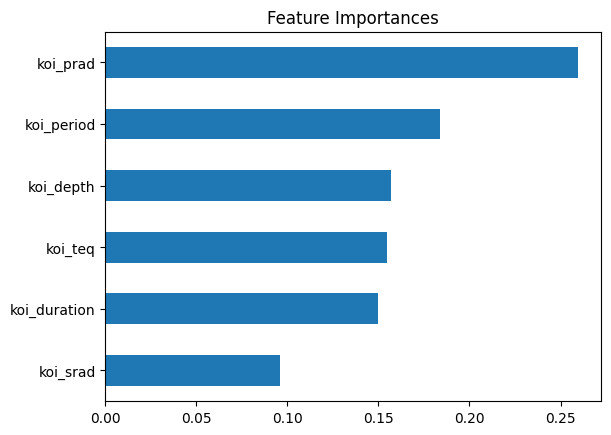

In [24]:
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot.barh(title="Feature Importances")
plt.show()

In [25]:
import joblib
joblib.dump(rf, 'exoplanet_classifier.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("Model saved successfully!")


Model saved successfully!
